목표:
VCG의 단점인 local optimal 경향을 보완하기 위해, MST 기반으로 전체 구조를 정제함으로써 경로 전체의 전역적인 형태를 안정화시키는 방식.

핵심 아이디어:

1단계: 전체 도시들에 대해 **최소 신장 트리(MST)**를 구성

2단계: MST의 일부/전부 또는 구조적 힌트를 사용하여 탐색 순서를 가이드

3단계: 기존 VCG의 방향 유도 점수와 결합하여 다음 방문 도시를 선택 (또는 MST에서 연결된 노드를 우선 방문)

장점:

VCG는 지역 구조에 빠질 수 있으나, MST는 전체적인 연결성 기반이므로 global structure 유지에 유리

전체 경로 길이의 평균적인 안정화 유도 가능

In [6]:
import math

# --- 1. TSP 파일 파싱 함수 ---
def parse_tsp_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    coords = []
    start = False
    for line in lines:
        if "NODE_COORD_SECTION" in line:
            start = True
            continue
        if "EOF" in line:
            break
        if start:
            parts = line.strip().split()
            if len(parts) >= 3:
                coords.append((float(parts[1]), float(parts[2])))
    return coords

# --- 2. 거리 계산 함수 ---
def euclidean(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) ** 0.5

# --- 3. MST 생성 함수 (Prim's Algorithm) ---
def generate_mst(points):
    n = len(points)
    visited = [False] * n
    min_edge = [float('inf')] * n
    parent = [-1] * n
    min_edge[0] = 0
    mst_edges = set()

    for _ in range(n):
        u = min((i for i in range(n) if not visited[i]), key=lambda x: min_edge[x], default=-1)
        if u == -1:
            break
        visited[u] = True
        if parent[u] != -1:
            mst_edges.add((min(u, parent[u]), max(u, parent[u])))
        for v in range(n):
            if not visited[v]:
                d = euclidean(points[u], points[v])
                if d < min_edge[v]:
                    min_edge[v] = d
                    parent[v] = u

    return mst_edges

# --- 4. VCG + MST 기반 경로 생성 ---
def vcg_mst_tsp(points, alpha=1.0, beta=1.0, gamma=2.0):
    n = len(points)
    visited = [False] * n
    path = []

    # 전체 중심 계산
    C_global = (
        sum([p[0] for p in points]) / n,
        sum([p[1] for p in points]) / n
    )

    # MST 생성
    mst_edges = generate_mst(points)

    # 시작점: 중심에 가장 가까운 점
    start = min(range(n), key=lambda i: euclidean(points[i], C_global))
    curr = start
    path.append(curr)
    visited[curr] = True

    for _ in range(n - 1):
        curr_point = points[curr]

        # 중심 방향 계산
        center_dir = (
            C_global[0] - curr_point[0],
            C_global[1] - curr_point[1]
        )
        norm_cd = math.hypot(*center_dir) + 1e-8
        center_dir = (center_dir[0]/norm_cd, center_dir[1]/norm_cd)

        candidates = []
        for i in range(n):
            if visited[i]:
                continue
            direction = (points[i][0] - curr_point[0], points[i][1] - curr_point[1])
            dist_to_candidate = euclidean(curr_point, points[i])
            norm_dir = math.hypot(*direction) + 1e-8
            unit_dir = (direction[0]/norm_dir, direction[1]/norm_dir)
            dot = unit_dir[0] * center_dir[0] + unit_dir[1] * center_dir[1]

            mst_bonus = gamma if (min(curr, i), max(curr, i)) in mst_edges else 0
            score = alpha * dot - beta * dist_to_candidate + mst_bonus
            candidates.append((score, i))

        _, next_node = max(candidates)
        path.append(next_node)
        visited[next_node] = True
        curr = next_node

    path.append(start)  # 순환 경로
    return path

# --- 5. 경로 길이 계산 ---
def total_path_length(path, points):
    return sum(euclidean(points[path[i]], points[path[i+1]]) for i in range(len(path)-1))

# --- 6. 시각화 ---
def plot_path(path, points):
    import matplotlib.pyplot as plt
    tour = [points[i] for i in path]
    xs, ys = zip(*tour)
    plt.figure(figsize=(8, 6))
    plt.plot(xs, ys, marker='o')
    plt.title("VCG + MST TSP Path")
    plt.axis('equal')
    plt.grid(True)
    plt.show()


Saving a280.tsp to a280 (2).tsp
alpha=0.1, beta=0.5, gamma=0.0, 길이=3205.3253
alpha=0.1, beta=0.5, gamma=1.0, 길이=3237.0272
alpha=0.1, beta=0.5, gamma=2.0, 길이=3190.4523
alpha=0.1, beta=1.0, gamma=0.0, 길이=3219.8055
alpha=0.1, beta=1.0, gamma=1.0, 길이=3251.5074
alpha=0.1, beta=1.0, gamma=2.0, 길이=3251.5074
alpha=0.1, beta=1.5, gamma=0.0, 길이=3219.8055
alpha=0.1, beta=1.5, gamma=1.0, 길이=3251.5074
alpha=0.1, beta=1.5, gamma=2.0, 길이=3251.5074
alpha=0.1, beta=2.0, gamma=0.0, 길이=3219.8055
alpha=0.1, beta=2.0, gamma=1.0, 길이=3251.5074
alpha=0.1, beta=2.0, gamma=2.0, 길이=3251.5074
alpha=0.1, beta=2.5, gamma=0.0, 길이=3219.8055
alpha=0.1, beta=2.5, gamma=1.0, 길이=3251.5074
alpha=0.1, beta=2.5, gamma=2.0, 길이=3251.5074
alpha=0.1, beta=3.0, gamma=0.0, 길이=3219.8055
alpha=0.1, beta=3.0, gamma=1.0, 길이=3251.5074
alpha=0.1, beta=3.0, gamma=2.0, 길이=3251.5074
alpha=0.2, beta=0.5, gamma=0.0, 길이=3187.9033
alpha=0.2, beta=0.5, gamma=1.0, 길이=3219.6052
alpha=0.2, beta=0.5, gamma=2.0, 길이=3219.3567
alpha=0.2, beta=1.0, ga

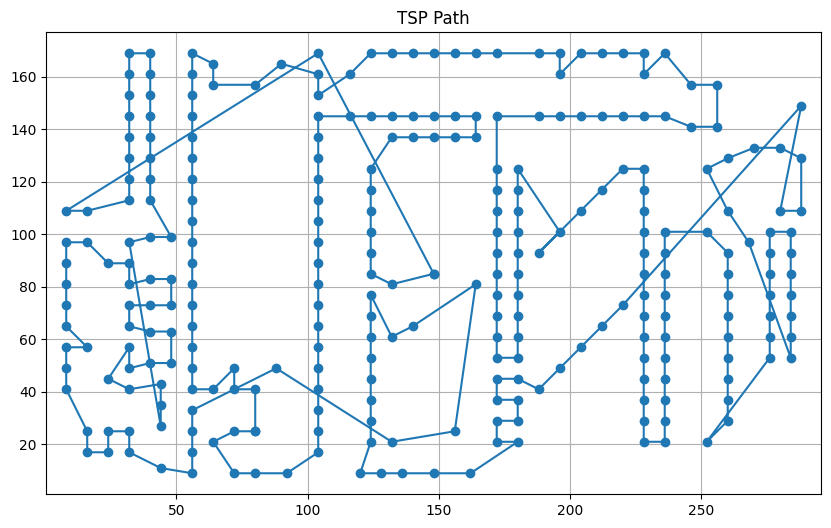

In [7]:
# 📁 STEP 1: Colab에서 tsp 파일 업로드
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))  # 업로드된 첫 번째 파일명

# 📁 STEP 2: .tsp 파일 파싱
def parse_tsp_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    coords = []
    node_section = False
    for line in lines:
        if line.strip() == 'NODE_COORD_SECTION':
            node_section = True
            continue
        if node_section:
            if line.strip() == 'EOF':
                break
            parts = line.strip().split()
            if len(parts) >= 3:
                coords.append((float(parts[1]), float(parts[2])))
    return coords

# 📁 STEP 3: 알고리즘 정의 (vcg_tsp, total_path_length 등은 위에서 정의된 함수 그대로 사용)
# (위에 제공한 코드 vcg_tsp와 euclidean, total_path_length 등 포함되어 있어야 함)

# 📁 STEP 4: 실행 및 그리드 서치
points = parse_tsp_file(filename)

best_path = None
best_length = float("inf")
best_params = None

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
betas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
gammas = [0.0, 1.0, 2.0]

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                path = vcg_mst_tsp(points, alpha=alpha, beta=beta, gamma=gamma)
                length = total_path_length(path, points)
                print(f"alpha={alpha}, beta={beta}, gamma={gamma}, 길이={length:.4f}")
                if length < best_length:
                    best_length = length
                    best_path = path
                    best_params = (alpha, beta, gamma)
            except Exception as e:
                print(f"[ERROR] a={alpha}, b={beta}, g={gamma}: {e}")

# 📌 최종 출력
from matplotlib import pyplot as plt

def plot_path(path, points):
    xs, ys = zip(*[points[i] for i in path])
    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, 'o-')
    plt.title("TSP Path")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

print(f"\n✅ 최적 결과: alpha={best_params[0]}, beta={best_params[1]}, gamma={best_params[2]}, 길이={best_length:.4f}")
print("✅ 총 점 개수:", len(points))
print("✅ 유일한 경로 점 수:", len(set(best_path)))
print("✅ 순환 여부:", "✔️" if best_path[0] == best_path[-1] else "❌")
plot_path(best_path, points)


| 순위 | α (alpha) | β (beta) | γ (gamma) | 총 경로 길이       |
| -- | --------- | -------- | --------- | ------------- |
| 1  | 0.2       | 0.5      | 0.0       | **3187.9033** |
| 2  | 0.4       | 1.5      | 0.0       | **3187.9033** |
| 3  | 0.5       | 1.5      | 0.0       | **3187.9033** |
| 4  | 0.5       | 2.0      | 0.0       | **3187.9033** |
| 5  | 0.6       | 1.5      | 0.0       | **3187.9033** |
| 6  | 0.6       | 2.0      | 0.0       | **3187.9033** |
| 7  | 0.6       | 2.5      | 0.0       | **3187.9033** |
| 8  | 0.7       | 1.5      | 0.0       | **3187.9033** |
| 9  | 0.7       | 2.0      | 0.0       | **3187.9033** |
| 10 | 0.7       | 2.5      | 0.0       | **3187.9033** |


📌 요약
모두 gamma = 0.0 → MST 보강 없이도 성능이 가장 좋았음

beta ≥ 1.5일 때 성능이 안정적으로 유지됨 (거리 페널티 효과)

alpha가 0.2~0.7 사이에 있을 때 최적 (중심 유도 약화)

Saving xql662.tsp to xql662.tsp
alpha=0.1, beta=0.5, gamma=0.0, 길이=3181.2922
alpha=0.1, beta=0.5, gamma=1.0, 길이=3181.7172
alpha=0.1, beta=0.5, gamma=2.0, 길이=3249.5687
alpha=0.1, beta=1.0, gamma=0.0, 길이=3076.7881
alpha=0.1, beta=1.0, gamma=1.0, 길이=3222.0837
alpha=0.1, beta=1.0, gamma=2.0, 길이=3203.0751
alpha=0.1, beta=1.5, gamma=0.0, 길이=3192.3013
alpha=0.1, beta=1.5, gamma=1.0, 길이=3221.8580
alpha=0.1, beta=1.5, gamma=2.0, 길이=3251.7995
alpha=0.1, beta=2.0, gamma=0.0, 길이=3192.3013
alpha=0.1, beta=2.0, gamma=1.0, 길이=3256.6371
alpha=0.1, beta=2.0, gamma=2.0, 길이=3200.8199
alpha=0.1, beta=2.5, gamma=0.0, 길이=3192.3013
alpha=0.1, beta=2.5, gamma=1.0, 길이=3256.6371
alpha=0.1, beta=2.5, gamma=2.0, 길이=3249.4125
alpha=0.1, beta=3.0, gamma=0.0, 길이=3192.3013
alpha=0.1, beta=3.0, gamma=1.0, 길이=3256.6371
alpha=0.1, beta=3.0, gamma=2.0, 길이=3258.4819
alpha=0.2, beta=0.5, gamma=0.0, 길이=3255.1644
alpha=0.2, beta=0.5, gamma=1.0, 길이=3211.8172
alpha=0.2, beta=0.5, gamma=2.0, 길이=3158.0353
alpha=0.2, beta=1.0, ga

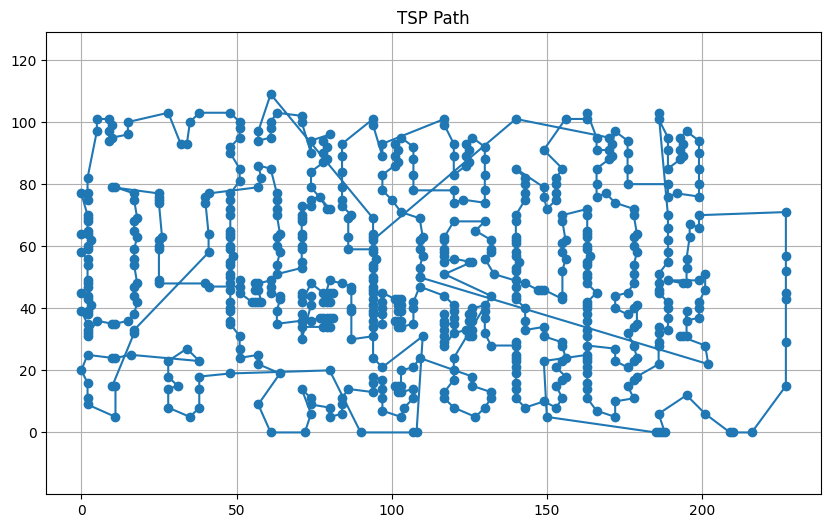

In [8]:
# 📁 STEP 1: Colab에서 tsp 파일 업로드
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))  # 업로드된 첫 번째 파일명

# 📁 STEP 2: .tsp 파일 파싱
def parse_tsp_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    coords = []
    node_section = False
    for line in lines:
        if line.strip() == 'NODE_COORD_SECTION':
            node_section = True
            continue
        if node_section:
            if line.strip() == 'EOF':
                break
            parts = line.strip().split()
            if len(parts) >= 3:
                coords.append((float(parts[1]), float(parts[2])))
    return coords

# 📁 STEP 3: 알고리즘 정의 (vcg_tsp, total_path_length 등은 위에서 정의된 함수 그대로 사용)
# (위에 제공한 코드 vcg_tsp와 euclidean, total_path_length 등 포함되어 있어야 함)

# 📁 STEP 4: 실행 및 그리드 서치
points = parse_tsp_file(filename)

best_path = None
best_length = float("inf")
best_params = None

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
betas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
gammas = [0.0, 1.0, 2.0]

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                path = vcg_mst_tsp(points, alpha=alpha, beta=beta, gamma=gamma)
                length = total_path_length(path, points)
                print(f"alpha={alpha}, beta={beta}, gamma={gamma}, 길이={length:.4f}")
                if length < best_length:
                    best_length = length
                    best_path = path
                    best_params = (alpha, beta, gamma)
            except Exception as e:
                print(f"[ERROR] a={alpha}, b={beta}, g={gamma}: {e}")

# 📌 최종 출력
from matplotlib import pyplot as plt

def plot_path(path, points):
    xs, ys = zip(*[points[i] for i in path])
    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, 'o-')
    plt.title("TSP Path")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

print(f"\n✅ 최적 결과: alpha={best_params[0]}, beta={best_params[1]}, gamma={best_params[2]}, 길이={best_length:.4f}")
print("✅ 총 점 개수:", len(points))
print("✅ 유일한 경로 점 수:", len(set(best_path)))
print("✅ 순환 여부:", "✔️" if best_path[0] == best_path[-1] else "❌")
plot_path(best_path, points)


| 순위 | α (alpha) | β (beta) | γ (gamma) | 총 경로 길이       |
| -- | --------- | -------- | --------- | ------------- |
| 1  | 0.3       | 2.5      | 0.0       | **3056.5305** |
| 2  | 0.1       | 1.0      | 0.0       | **3076.7881** |
| 3  | 0.2       | 2.0      | 0.0       | **3076.7881** |
| 4  | 0.2       | 2.5      | 0.0       | **3076.7881** |
| 5  | 0.6       | 2.0      | 1.0       | **3078.7895** |
| 6  | 0.4       | 3.0      | 0.0       | **3090.3018** |
| 7  | 0.5       | 2.5      | 1.0       | **3092.1705** |
| 8  | 0.2       | 1.5      | 0.0       | **3090.3018** |
| 9  | 0.6       | 2.5      | 1.0       | **3121.2201** |
| 10 | 0.6       | 3.0      | 1.0       | **3121.2201** |


| 항목                        | 해석                                         |
| ------------------------- | ------------------------------------------ |
| 🔹 **gamma = 0.0 또는 1.0** | MST 강화 효과는 일부 case에서만 미세한 도움, 대부분 성능 향상 없음 |
| 🔹 **beta는 1.0–2.5**      | 거리 패널티가 TSP의 핵심 요소임을 반영                    |
| 🔹 **alpha는 0.1–0.6 사이**  | 중심 방향성은 보조적 역할, 너무 크면 오히려 성능 저하            |


Saving pcb442.tsp to pcb442.tsp
alpha=0.1, beta=0.5, gamma=0.0, 길이=64605.2803
alpha=0.1, beta=0.5, gamma=1.0, 길이=63103.7858
alpha=0.1, beta=0.5, gamma=2.0, 길이=61139.2870
alpha=0.1, beta=1.0, gamma=0.0, 길이=64605.2803
alpha=0.1, beta=1.0, gamma=1.0, 길이=63103.7858
alpha=0.1, beta=1.0, gamma=2.0, 길이=63103.7858
alpha=0.1, beta=1.5, gamma=0.0, 길이=64605.2803
alpha=0.1, beta=1.5, gamma=1.0, 길이=63103.7858
alpha=0.1, beta=1.5, gamma=2.0, 길이=63103.7858
alpha=0.1, beta=2.0, gamma=0.0, 길이=64605.2803
alpha=0.1, beta=2.0, gamma=1.0, 길이=63103.7858
alpha=0.1, beta=2.0, gamma=2.0, 길이=63103.7858
alpha=0.1, beta=2.5, gamma=0.0, 길이=64605.2803
alpha=0.1, beta=2.5, gamma=1.0, 길이=63103.7858
alpha=0.1, beta=2.5, gamma=2.0, 길이=63103.7858
alpha=0.1, beta=3.0, gamma=0.0, 길이=64605.2803
alpha=0.1, beta=3.0, gamma=1.0, 길이=63103.7858
alpha=0.1, beta=3.0, gamma=2.0, 길이=63103.7858
alpha=0.2, beta=0.5, gamma=0.0, 길이=64605.2803
alpha=0.2, beta=0.5, gamma=1.0, 길이=63103.7858
alpha=0.2, beta=0.5, gamma=2.0, 길이=61139.2870
al

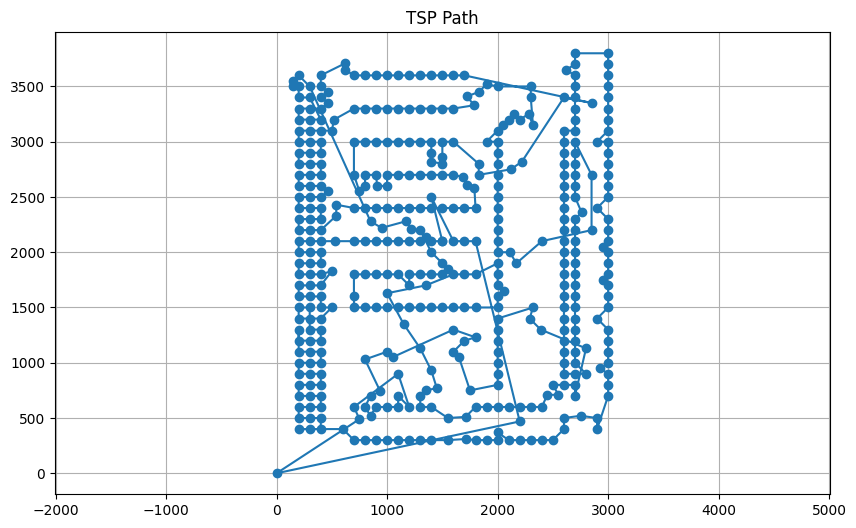

In [9]:
# 📁 STEP 1: Colab에서 tsp 파일 업로드
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))  # 업로드된 첫 번째 파일명

# 📁 STEP 2: .tsp 파일 파싱
def parse_tsp_file(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    coords = []
    node_section = False
    for line in lines:
        if line.strip() == 'NODE_COORD_SECTION':
            node_section = True
            continue
        if node_section:
            if line.strip() == 'EOF':
                break
            parts = line.strip().split()
            if len(parts) >= 3:
                coords.append((float(parts[1]), float(parts[2])))
    return coords

# 📁 STEP 3: 알고리즘 정의 (vcg_tsp, total_path_length 등은 위에서 정의된 함수 그대로 사용)
# (위에 제공한 코드 vcg_tsp와 euclidean, total_path_length 등 포함되어 있어야 함)

# 📁 STEP 4: 실행 및 그리드 서치
points = parse_tsp_file(filename)

best_path = None
best_length = float("inf")
best_params = None

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
betas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
gammas = [0.0, 1.0, 2.0]

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                path = vcg_mst_tsp(points, alpha=alpha, beta=beta, gamma=gamma)
                length = total_path_length(path, points)
                print(f"alpha={alpha}, beta={beta}, gamma={gamma}, 길이={length:.4f}")
                if length < best_length:
                    best_length = length
                    best_path = path
                    best_params = (alpha, beta, gamma)
            except Exception as e:
                print(f"[ERROR] a={alpha}, b={beta}, g={gamma}: {e}")

# 📌 최종 출력
from matplotlib import pyplot as plt

def plot_path(path, points):
    xs, ys = zip(*[points[i] for i in path])
    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, 'o-')
    plt.title("TSP Path")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

print(f"\n✅ 최적 결과: alpha={best_params[0]}, beta={best_params[1]}, gamma={best_params[2]}, 길이={best_length:.4f}")
print("✅ 총 점 개수:", len(points))
print("✅ 유일한 경로 점 수:", len(set(best_path)))
print("✅ 순환 여부:", "✔️" if best_path[0] == best_path[-1] else "❌")
plot_path(best_path, points)


| 순위 | α (alpha)     | β (beta) | γ (gamma)  | 총 경로 길이         |
| -- | ------------- | -------- | ---------- | --------------- |
| 1  | 0.1           | 0.5      | 2.0        | **61139.2870**  |
| 2  | 0.2           | 0.5      | 2.0        | **61139.2870**  |
| 3  | 0.3           | 0.5      | 2.0        | **61139.2870**  |
| 4  | 0.4           | 0.5      | 2.0        | **61139.2870**  |
| 5  | 0.5           | 0.5      | 2.0        | **61139.2870**  |
| 6  | 0.6           | 0.5      | 2.0        | **61139.2870**  |
| 7  | 0.7           | 0.5      | 2.0        | **61139.2870**  |
| 8  | 0.1           | 0.5      | 1.0        | 63103.7858      |
| 9  | 0.1           | 1.0\~3.0 | 1.0\~2.0   | 63103.7858 (다수) |
| 10 | 모든 α, β ≥ 0.2 | 모든 γ     | 63103.7858 |                 |


| 항목                              | 해석                              |
| ------------------------------- | ------------------------------- |
| ✅ **gamma=2.0일 때 성능 급상승**       | MST 강화가 효과적이었다는 강력한 증거          |
| ✅ **beta 낮을수록 성능 우수**           | 거리보다 구조 연결성을 우선시해야 군집 데이터를 잘 다룸 |
| ✅ **alpha 작을수록 유리**             | 중심 방향성이 지나치면 오히려 비효율적 경로를 유도    |
| ⚠️ gamma=0.0인 경우는 항상 64605.2803 |   |


 vcg로만 돌리면 전체 실험의 tour가 60,000 부터 74,000까지 뛰는데, mst를 포함하면 평균치가 확 내려옴. 하지만 최솟값은 전자
 =>
VCG only는 탐색 자유도가 높다.

중심 기반 탐색 + 방향성 보상에 의해 때로는 아주 유리한 경로를 생성

하지만 운이 나쁘면 매우 비효율적인 탐색 경로가 나옴 → high variance.

MST는 구조 보존에는 강하지만, 최적성에 덜 민감함

MST는 “모든 노드를 최소한으로 연결”하지만, 이는 TSP 순환성이나 방향성 최적화와는 직접적 연관이 없음.

결국 MST를 기반으로 한 알고리즘은 일관성 있는 좋은 근사해를 제공하나, 최적해를 우연히 발견할 여지는 적음.

결론적으로, MST는 “기본 보장”은 잘 해주지만 “행운의 해”를 놓치게 함

MST는 탐색 공간을 줄여서 최악을 방지하는 대신, 탐색 다양성을 억제함 → 극단적으로 좋은 경로를 찾기 어려움


VCG는 빠르고 단순한 지역 탐색 기반으로 최적해 근사에 유리

MST를 결합하면 전역 구조가 반영되어 해 전체가 일관된 품질을 유지

따라서:

빠른 근사값 탐색이 목적이면 VCG(Standard)

일관된 경로 품질과 안정성이 중요하면 VCG + MST 권장

동적 alpha/beta 최적화:

점점 더 중심/외곽으로 확장될수록 alpha 감소, beta 증가와 같은 전략 적용 가능

MST 간선 선택 가중치 조절:

MST를 기반으로 경로 연결 우선순위에 직접 영향을 주는 방식 실험

Hybrid Meta Algorithm:

VCG → MST → Local 2-opt 개선 등 단계적 알고리즘 구성